# Assignment 2 - Machine Learning
## FEUP MIEIC - Inteligência Artificial *(EIC0029/IART)*



## Complete Assignment

*This Jupyter Notebook comprises of all the work developed for the 2nd Assignment of the Course Inteligencia Artificial (EIC0029/IART) of Mestrado Integrado em Engenharia Informática e Computação (MIEIC) at Fauldade de Engenharia da Universidade do Porto (FEUP)* 

## Index
>Although this document contains all work developed, in this repository you will also find the partial notebooks used throughout the developent process, devided by the items in this index, reachable through the links embeded in the aforementioned section

1. [Data Pre-processing](partials/pre-processing.ipynb)
2. [Decision Tree](partials/decision-tree.ipynb)
3. [K-Nearest Neighbor](partials/k-nearest-neighbor.ipynb)
4. [Neural Network](partials/neural-networl.ipynb)
5. [Model Comparison](partials/model-comparison.ipynb)
6. [Conclusions](partials/conclusions.ipynb)

***

## Introduction

This assignment had the objective of comparing the effectiveness of several algorithms to classify a class from a dataset.
For that, we used the European Soccer Database from https://www.kaggle.com/hugomathien/soccer. 
From this dataset, we tried to apply machine learning algorithms to predict the outcome of a football match.
We start to analyze and normalize the data. After applying it the three selected algorithms, we compare its results and effectiveness.


## 1. Data Pre-processing 
In this section we will implement and document our approach to extract, manipulate, and in essence pre-process the data that will be used to train and test our machine learning models. The main goal of this step is to reduce the processing time of each algorithm and increase their precision by using only the relevant information.

We started by extracting all important data from the dataset provided. Because there all multiple missing values in the <i>team_attributes</i> table, we chose not to use it. We also decided not to use the tables <i> country </i>, <i> league </i> and <i> player </i> since we considered their data irrelevant to our problem.

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import sqlite3
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

In [4]:
# Connecting to database

database = "database.sqlite"
con = sqlite3.connect(database)

In [5]:
# Extracting relevant data from the database

matches_df = pd.read_sql("""SELECT * from MATCH""", con)
teams_df = pd.read_sql("""SELECT * from TEAM""", con)
player_attributes_df = pd.read_sql("""SELECT * from PLAYER_ATTRIBUTES""", con)
team_attributes_df = pd.read_sql("""SELECT * from TEAM_ATTRIBUTES""", con)

At a first glance we verified the existence of too many columns so we decided to make some adjustments: we started by choosing the features we wanted to keep and after that we tried to aggregate all related variables (such as players' info and odds) and have some "background" info of each team in a match.

In [6]:
# Selecting features to keep

matches_kept_columns = ["id", "league_id", "date", "home_team_api_id", "away_team_api_id", "home_team_goal", "away_team_goal"]

In [7]:
# Selecting players labels

home_players = ["home_player_" + str(x) for x in range(1, 12)]
away_players = ["away_player_" + str(x) for x in range(1, 12)]


# Merge features to keep

matches_kept_columns = matches_kept_columns + home_players
matches_kept_columns = matches_kept_columns + away_players
matches_df = matches_df[matches_kept_columns]

In [8]:
#Geting overall ratings for all players from the player_attributes table

for player in home_players:
    matches_df = pd.merge(matches_df, player_attributes_df[["id", "overall_rating"]], left_on=[player], right_on=["id"], suffixes=["", "_" + player])
for player in away_players:
    matches_df = pd.merge(matches_df, player_attributes_df[["id", "overall_rating"]], left_on=[player], right_on=["id"], suffixes=["", "_" + player])

    
matches_df = matches_df.rename(columns={"overall_rating": "overall_rating_home_player_1"})

matches_df['overall_rating_home'] = matches_df[['overall_rating_' + p for p in home_players]].sum(axis=1)
matches_df['overall_rating_away'] = matches_df[['overall_rating_' + p for p in away_players]].sum(axis=1)
matches_df['overall_rating_difference'] = matches_df['overall_rating_home'] - matches_df['overall_rating_away']

matches_df['mean_overall_rating_home'] = matches_df[['overall_rating_' + p for p in home_players]].mean(axis=1)
matches_df['mean_overall_rating_away'] = matches_df[['overall_rating_' + p for p in away_players]].mean(axis=1)    

Since our goal was reducing the number of features of a <i>match</i>, we ultimately ended up erasing all variables related to a specific player and keep only the mean values of the players' overall attributes and the difference between the best and worst players of each teams.

In [9]:
# Removing individual player info

for c in matches_df.columns:
    if '_player_' in c:
        matches_df = matches_df.drop(c, axis=1)

We considered that was important to understand the evolution of a team between matches, so we developed a method that is able to extract the results of the last 5 matches of a team. 

In [10]:
#function to calculate last 5 games performance
def last5(team_id, date, match_t):
     
    mat = match_t[(match_t['date'] < date)]
    mat = mat[mat['home_team_api_id'] == team_id]
    
    mat5 = mat.head(5)
    if len(mat5.index) < 5:
        return -1
    mat5['Home result'] = 0
    mat5['Home result'] = np.where(mat5['home_team_goal'] > mat5['away_team_goal'], 3, mat5['Home result'])
    mat5['Home result'] = np.where(mat5['home_team_goal'] == mat5['away_team_goal'], 1, mat5['Home result'])
    total = mat5['Home result'].sum()
    return total

match_t = matches_df[['home_team_api_id', 'away_team_api_id','date', 'home_team_goal', 'away_team_goal']].copy()
match_t['date'] = pd.to_datetime(match_t['date'])
match_t.sort_values(by=['date'], inplace=True, ascending=False) 
matches_df['Home_last5'] = 0
matches_df['Away_last5'] = 0
perc = 0
for i in matches_df.index:
    Htotal = last5(match_t['home_team_api_id'].iloc[i], match_t['date'].iloc[i], match_t)
    Atotal = last5(match_t['away_team_api_id'].iloc[i], match_t['date'].iloc[i], match_t)
    matches_df['Home_last5'].values[i] = Htotal
    matches_df['Away_last5'].values[i] = Atotal
    if i % 655 == 0:
        perc += 10
        print(" ", perc, "%", end=" ")
#Dont considerate games that dont have 5 previous history 
matches_df = matches_df[matches_df.Home_last5 != -1]
matches_df = matches_df[matches_df.Away_last5 != -1]

10 %  20 %  30 %  40 %  50 %  60 %  70 %  80 %  90 %  100 %

Finally, we decided to also include the odds in our final data set. There were many <i>null</i> values so we replaced them with their mean values. TODO: FALAR MAIS SOBRE ISTO!

In [11]:
matches_aux = pd.read_sql("""SELECT * FROM MATCH""" ,con)

#Select all bet columns (removed PSA, PSH, PSD because they are almost all NaN)

bet_columns = ["B365H", "B365A", "B365D", "BWH", "BWD", "BWA", "IWH", "IWD", "IWA", "LBH", "LBD", "LBA", "WHH", "WHD", "WHA", "SJH", "SJD", "SJA", "VCH", "VCD", "VCA", "GBH", "GBD", "GBA", "BSH", "BSD", "BSA"]


#Get specific columns for bets on home and draw

bet_columns_home = ["B365H", "BWH","IWH", "LBH", "WHH", "SJH", "VCH", "GBH","BSH"]
bet_columns_draw = ["B365D", "BWD","IWD", "LBD", "WHD", "SJD", "VCD", "GBD","BSD"]
bet_columns_away = ["B365A", "BWA","IWA", "LBA", "WHA", "SJA", "VCA", "GBA","BSA"]


#Calculate mean values for bets on home team and draw. Add these values to match table

matches_df['mean_bets_home'] = matches_aux[bet_columns_home].mean(axis=1)
matches_df['mean_bets_draw'] = matches_aux[bet_columns_draw].mean(axis=1)
matches_df['mean_bets_away'] = matches_aux[bet_columns_away].mean(axis=1)


#Replace NaN values (on bets) with mean values 

matches_df.fillna(matches_df.mean(), inplace=True)

We calculated our class variable by getting the goals difference in each match and then mapping it into the correspondent class.

In [12]:
# Getting the goal difference

matches_df['goal_diff'] = matches_df['home_team_goal'] - matches_df['away_team_goal']

matches_df['Game Result'] = 'Defeat'
matches_df['Game Result'] = np.where(matches_df['goal_diff'] == 0, 'Draw', matches_df['Game Result'])
matches_df['Game Result'] = np.where(matches_df['goal_diff'] > 0, 'Win', matches_df['Game Result'])


Lastly we dropped all unnecessary variables.

In [13]:
#Removing unnecessary data

matches_df = matches_df.drop([ 'id', 'league_id', 'date', 'home_team_api_id','away_team_api_id','home_team_goal','away_team_goal','goal_diff'], axis=1)
matches_df.head()

,overall_rating_home,overall_rating_away,overall_rating_difference,mean_overall_rating_home,mean_overall_rating_away,Home_last5,Away_last5,mean_bets_home,mean_bets_draw,mean_bets_away,Game Result
0,746.0,783.0,-37.0,67.818182,71.181818,1,1,1.765556,3.322222,4.164444,Draw
1,772.0,790.0,-18.0,70.181818,71.818182,8,11,1.898889,3.250000,3.616667,Defeat
2,780.0,719.0,61.0,70.909091,71.900000,9,8,2.462222,3.233333,2.544444,Win
3,688.0,717.0,-29.0,68.800000,71.700000,8,3,1.438889,3.805556,6.533333,Draw
5,809.0,778.0,31.0,73.545455,70.727273,7,8,4.606250,3.400000,1.688750,Defeat


We divided our data into a <b>training dataset</b> (the sample of data used to fit the model) and a <b>testing dataset</b> (the sample of data used to provide an unbiased evaluation of a model fit on the training dataset while tuning model hyperparameter), with a 70/30 random split.

In [16]:
# Getting the train and test sets


y = matches_df['Game Result']
X = matches_df.drop('Game Result', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3, 
                                                    random_state=42, 
                                                    stratify=y)



After some testing, we verified that our data set was still very <b>imbalanced</b> (very unequal number of instances of classes) and that our classification algorithms were very sensitive to it. Considering that we had already a small number of data, we opted for an <b>over-sampling</b> approach by duplicating samples of the classes with fewer instances. 

In [18]:
from imblearn.over_sampling import SMOTE

# Selecting our class variable (y) and extracting it from the features list (x)

X_train, y_train = SMOTE().fit_sample(X_train, y_train)

Since our dataset contains features highly variable in units (e.g.: odds and players overall), we agreed that <b>scaling</b> both our training and testing dataset was a good idea. 
It is also important to say that although this step is not so relevant for tree based models, algorithms such as k-nearest neighbor that uses Eucliden distance measure are very sensitive to magnitudes and hence should be scaled for all features to weigh in equally.

In [19]:
# Scaling data

scaler = preprocessing.StandardScaler().fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

## 2. Decision Tree 
In this section we will implpement a decision tree model.

In [20]:
from sklearn.tree import DecisionTreeClassifier 
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix


parameters = {'max_depth': range(5,100),
              'criterion': ['gini', 'entropy'],
              'splitter' : ['random', 'best']
             }

clf = GridSearchCV(DecisionTreeClassifier(), parameters, n_jobs=-1, cv=5)

clf.fit(X=X_train_scaled, y=y_train)

tree_model = clf.best_estimator_

print (clf.best_score_, clf.best_params_) 


0.4841269841269842 {'criterion': 'entropy', 'max_depth': 68, 'splitter': 'random'}


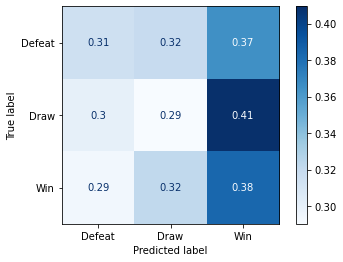

In [22]:
disp = plot_confusion_matrix(tree_model, X_test_scaled, y_test, normalize="true", cmap=plt.cm.Blues)

In [18]:
y_pred = tree_model.predict(X_test_scaled)

In [19]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

precision    recall  f1-score   support

      Defeat       0.46      0.46      0.46       720
        Draw       0.47      0.50      0.48       720
         Win       0.40      0.38      0.39       721

    accuracy                           0.44      2161
   macro avg       0.44      0.44      0.44      2161
weighted avg       0.44      0.44      0.44      2161



## 3. K-Nearest Neighbor 
In this section we will implement a K-nearest neighbor model.

In [21]:
from sklearn.neighbors import KNeighborsClassifier
#search for optimal parameters

grid_param = {
    'n_neighbors': [3, 5, 7, 11, 19],
    'weights':['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

#use gridsearch to test all values for n_neighbors
knn_best = GridSearchCV(KNeighborsClassifier(), grid_param, verbose = False, cv=3, n_jobs = -1)
#fit model to data
knn_best_result = knn_best.fit(X_test_scaled, y_test)

#check top performing n_neighbors value
knn_best.best_params_
#knn_best.best_score_
#knn_best.best_estimator_

{'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}

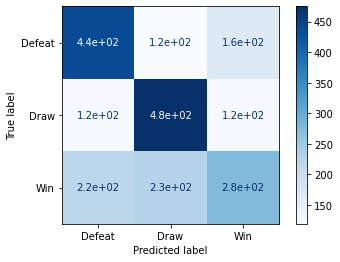

In [22]:
#best KNN

knnfinal = KNeighborsClassifier(n_neighbors = 3, metric='manhattan', weights='distance').fit(X_train_scaled,y_train)

CM_B = plot_confusion_matrix(knnfinal,X_test_scaled, y_test, cmap=plt.cm.Blues)
CM_B

In [24]:
from sklearn.metrics import accuracy_score
#KNN measures
y_pred = knnfinal.predict(X_test_scaled)

print("Accuracy score: ", accuracy_score(y_test, y_pred))
print("\nReport:")
print(classification_report(y_test, y_pred))

Accuracy score:  0.5502082369273484

Report:
              precision    recall  f1-score   support

      Defeat       0.56      0.61      0.58       720
        Draw       0.58      0.66      0.62       720
         Win       0.49      0.38      0.43       721

    accuracy                           0.55      2161
   macro avg       0.54      0.55      0.54      2161
weighted avg       0.54      0.55      0.54      2161



## 4. Neural Network 
In this section we will implpement a Neural Network model.

In [ ]:
from time import time

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV


# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})"
                  .format(results['mean_test_score'][candidate],
                          results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

n_iter_search = 10
parameter_space = {
    'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}

clf = MLPClassifier(verbose=1, random_state=21, learning_rate=1e-05)


random_search = RandomizedSearchCV(clf, param_distributions=parameter_space, n_iter=n_iter_search)

start = time()
print("Start")
random_search.fit(X_train_scaled, y_train)
print("End")
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search))
report(random_search.cv_results_)

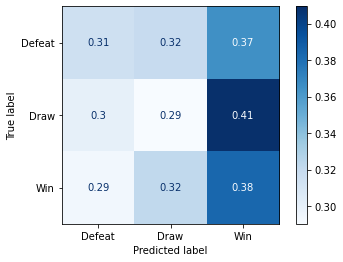

In [23]:
disp = plot_confusion_matrix(tree_model, X_test_scaled, y_test, normalize="true", cmap=plt.cm.Blues)

## 5. Model Comparison
In this section we will compare the results of the three models in sections 1, 2 and 3.

## 5. Conclusions
In this section we will draw conclusions.